# Imports and Device

In [1]:
import torch
import random
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import torch.nn as nn
import torch.nn.functional as F

import math
import time

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


# Load the data

In [3]:
root_path = "/scratch/04703/sravula/UTAFSDataNew/new_data"
chip_num = 0

In [4]:
import utils

data_dict = utils.grab_chip_data(root_path, chip_num, resample=True)

In [5]:
data_dict.keys()

dict_keys(['gt_matrix', 'gt_freqs', 'vf_matrix', 'y_matrix', 'y_freqs', 'og_matrix', 'og_freqs'])

In [6]:
print(data_dict['gt_matrix'].shape)
print(data_dict['vf_matrix'].shape)
print(data_dict['y_matrix'].shape)
print(data_dict['og_matrix'].shape)

(1024, 2, 2, 2)
(1000, 2, 2, 2)
(8, 2, 2, 2)
(1000, 2, 2, 2)


In [7]:
print(data_dict['gt_freqs'].shape)
print(data_dict['y_freqs'].shape)
print(data_dict['og_freqs'].shape)

(1024,)
(8,)
(1000,)


In [8]:
vf_data = utils.matrix_to_sparams(data_dict['vf_matrix'])
gt_data = utils.matrix_to_sparams(data_dict['gt_matrix'])
y_data = utils.matrix_to_sparams(data_dict['y_matrix'])
og_data = utils.matrix_to_sparams(data_dict['og_matrix'])

In [9]:
print(vf_data.shape)
print(gt_data.shape)
print(y_data.shape)
print(og_data.shape)

(3, 2, 1000)
(3, 2, 1024)
(3, 2, 8)
(3, 2, 1000)


In [10]:
og_freqs = data_dict['og_freqs']
gt_freqs = data_dict['gt_freqs']

In [11]:
print(og_freqs.shape)
print(gt_freqs.shape)

(1000,)
(1024,)


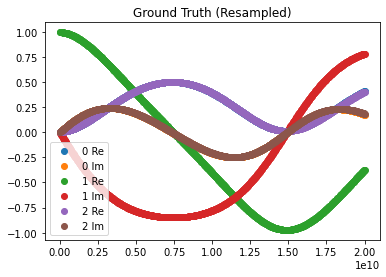

In [12]:
n_sparams = gt_data.shape[0]

plt.figure()
for i in range(n_sparams):
    plt.scatter(gt_freqs, gt_data[i,0,:].squeeze(), label=str(i)+" Re")
    plt.scatter(gt_freqs, gt_data[i,1,:].squeeze(), label=str(i)+" Im")
plt.legend()
plt.title("Ground Truth (Resampled)")
plt.show()

In [13]:
gt_mag = utils.to_mag(torch.from_numpy(gt_data))

print(gt_mag.shape)

torch.Size([3, 1024])


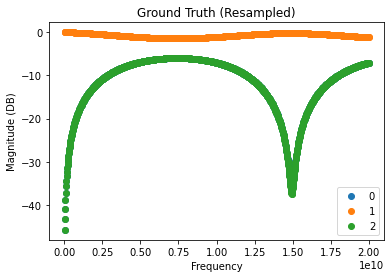

In [14]:
n_sparams = gt_mag.shape[0]

plt.figure()
for i in range(n_sparams):
    plt.scatter(gt_freqs, gt_mag[i], label=str(i))
plt.legend()
plt.title("Ground Truth (Resampled)")
plt.ylabel("Magnitude (DB)")
plt.xlabel("Frequency")
plt.show()

## Grab some measurements

In [15]:
PROBLEM_TYPE = "equal" #[random, equal, forecast, full]
LENGTH = len(gt_freqs)
M = 10

In [16]:
kept_inds, missing_inds = utils.get_inds(PROBLEM_TYPE, LENGTH, M)

In [17]:
print(LENGTH)
print(M)
print(len(kept_inds))
print(len(missing_inds))

1024
10
11
1013


## Make the final data

In [ ]:
x = torch.from_numpy(gt_data).type(torch.float32)
x = x.view(-1, LENGTH).unsqueeze(0)

In [ ]:
print(x.shape)

In [ ]:
y = torch.clone(x)[:, :, kept_inds]

In [ ]:
print(y.shape)

## Make sure that we can transform it back to the OG shape/size

In [ ]:
x_temp = utils.sparams_to_matrix(x)

In [ ]:
print(x_temp.shape)
print(x_temp.dtype)
print(x_temp.device)

In [ ]:
diff = x_temp - data_dict['gt_matrix']

print(torch.sum(diff).item())

## Visualize the data and observations

In [ ]:
fig, axes = plt.subplots(3,1, figsize=(16, 12))
axes = axes.flatten()

for j in range(x.shape[0]):
    for i in range(x.shape[1]):
        label = str(i//2) + (" re" if i % 2 == 0 else " im")
        axes[0].plot(gt_freqs, x[j,i,:].flatten(), label=label)
axes[0].set_title("Ground Truth")
axes[0].legend()

for j in range(x.shape[0]):
    for i in range(x.shape[1]):
        label = str(i//2) + (" re" if i % 2 == 0 else " im")
        axes[1].plot(gt_freqs[kept_inds], y[j,i,:].flatten(), label=label)
axes[1].set_title("Measurements - Linear interpolation")
axes[1].legend()

for j in range(x.shape[0]):
    for i in range(x.shape[1]):
        label = str(i//2) + (" re" if i % 2 == 0 else " im")
        axes[2].scatter(gt_freqs[kept_inds], y[j,i,:].flatten(), label=label)
axes[2].set_title("Measurements - Scatter")
axes[2].legend()

plt.show()

In [ ]:
x_mag = utils.to_mag(x)
y_mag = utils.to_mag(y)

print(x_mag.shape)
print(y_mag.shape)

In [ ]:
fig, axes = plt.subplots(3,1, figsize=(16, 12))
axes = axes.flatten()

for j in range(x_mag.shape[0]):
    axes[0].plot(gt_freqs, x_mag[j], label=str(j))
axes[0].set_title("Ground Truth")
axes[0].set_ylabel("Magnitude (DB)")
axes[0].legend()

for j in range(x_mag.shape[0]):
    axes[1].plot(gt_freqs[kept_inds], y_mag[j], label=str(j))
axes[1].set_title("Measurements - Linear interpolation in mag")
axes[1].set_ylabel("Magnitude (DB)")
axes[1].legend()

for j in range(x_mag.shape[0]):
    axes[2].scatter(gt_freqs[kept_inds], y_mag[j], label=str(j))
axes[2].set_title("Measurements - Scatter")
axes[2].set_ylabel("Magnitude (DB)")
axes[2].set_xlabel("Frequency (Hz)")
axes[2].legend()

plt.show()

# Set up the network

In [ ]:
LR = 1e-4 # learning rate
NUM_ITER = 50000 # number iterations

NZ = y.shape[1]
NGF = 256

BS = y.shape[0]
NC = y.shape[1]

In [ ]:
from models import ENC_DEC

KERNEL_SIZE = 3

net = ENC_DEC(bs=BS, nz=NZ, ngf=NGF, output_size=LENGTH, nc=NC, kernel_size=KERNEL_SIZE)
net = net.to(device)

In [ ]:
test_out = net.forward_with_z()
print(test_out.shape)

In [ ]:
pytorch_total_params = sum(p.numel() for p in net.parameters() if p.requires_grad)

print("TOTAL PARAMS: ", pytorch_total_params)

# (Testing) Fit Interp

In [ ]:
import scipy

y_np = y.cpu().detach().numpy()

Interpolate = scipy.interpolate.interp1d(kept_inds, y_np, fill_value='extrapolate')

In [ ]:
y_interp = Interpolate(np.arange(LENGTH))

print(y_interp.shape)

In [ ]:
fig, axes = plt.subplots(2,1, figsize=(16, 8))
axes = axes.flatten()

for j in range(x.shape[0]):
    for i in range(x.shape[1]):
        label = str(i//2) + (" re" if i % 2 == 0 else " im")
        axes[0].plot(gt_freqs, x[j,i,:].flatten(), label=label)
        axes[0].scatter(gt_freqs[kept_inds], y[j,i].cpu())
axes[0].set_title("Ground Truth")
axes[0].legend()

for j in range(x.shape[0]):
    for i in range(x.shape[1]):
        label = str(i//2) + (" re" if i % 2 == 0 else " im")
        axes[1].plot(gt_freqs, y_interp[j,i,:].flatten(), label=label)
        axes[1].scatter(gt_freqs[kept_inds], y[j,i].cpu())
axes[1].set_title("Measurements - Linear interpolation")
axes[1].legend()

plt.show()

In [ ]:
y_interp_mag = utils.to_mag(torch.from_numpy(y_interp))

print(y_interp_mag.shape)

In [ ]:
fig, axes = plt.subplots(2,1, figsize=(16, 8))
axes = axes.flatten()

for j in range(x_mag.shape[0]):
    axes[0].plot(gt_freqs, x_mag[j], label=str(j))
    axes[0].scatter(gt_freqs[kept_inds], y_mag[j])
axes[0].set_title("Ground Truth")
axes[0].set_ylabel("Magnitude (DB)")
axes[0].legend()

for j in range(x_mag.shape[0]):
    axes[1].plot(gt_freqs, y_interp_mag[j], label=str(j))
    axes[1].scatter(gt_freqs[kept_inds], y_mag[j])
axes[1].set_title("Measurements - Linear interpolation (in complex --> mag)")
axes[1].set_ylabel("Magnitude (DB)")
axes[1].set_xlabel("Frequency (Hz)")
axes[1].legend()

plt.show()

In [ ]:
criterion = torch.nn.MSELoss()
criterion = criterion.to(device)

In [ ]:
net = net.train()

optim = torch.optim.Adam(net.parameters(), lr=LR)

NUM_ITER_PRETRAIN = 1000

train_losses = []

y_interp = torch.from_numpy(y_interp).type(torch.float32)
y_interp = y_interp.to(device)

In [ ]:
tic = time.time()
for i in range(NUM_ITER_PRETRAIN):
    net.perturb_noise(0.01) 
    
    optim.zero_grad()
    
    out = net.forward_with_z()
    train_loss = criterion(out, y_interp)
    
    train_loss.backward()
    optim.step()
    
    with torch.no_grad():
        train_losses.append(train_loss.item())

        if (i+1)%100 == 0 or i == 0:
            toc = time.time()
            print("ITER ", str(i))
            print("TIME: ", str(toc - tic))
            print()

In [ ]:
out = out.detach().cpu().numpy()

fig, axes = plt.subplots(3,1, figsize=(16, 12))
axes = axes.flatten()

for j in range(x.shape[0]):
    for i in range(x.shape[1]):
        label = str(i//2) + (" re" if i % 2 == 0 else " im")
        axes[0].plot(gt_freqs, x[j,i,:].cpu().flatten(), label=label)
axes[0].set_title("Ground Truth")
axes[0].legend()

for j in range(x.shape[0]):
    for i in range(x.shape[1]):
        label = str(i//2) + (" re" if i % 2 == 0 else " im")
        axes[1].plot(gt_freqs, out[j,i,:].flatten(), label=label)
axes[1].set_title("Last Output")
axes[1].legend()

for j in range(x.shape[0]):
    for i in range(x.shape[1]):
        label = str(i//2) + (" re" if i % 2 == 0 else " im")
        axes[2].plot(gt_freqs, y_interp[j,i,:].cpu().flatten(), label=label)
axes[2].set_title("Measurements - Linear interpolation")
axes[2].legend()

plt.show()

In [ ]:
out_mag = utils.to_mag(torch.from_numpy(out))

print(out_mag.shape)

In [ ]:
fig, axes = plt.subplots(3,1, figsize=(16, 12))
axes = axes.flatten()

for j in range(x_mag.shape[0]):
    axes[0].plot(gt_freqs, x_mag[j], label=str(j))
axes[0].set_title("Ground Truth")
axes[0].set_ylabel("Magnitude (DB)")
axes[0].legend()

for j in range(x_mag.shape[0]):
    axes[1].plot(gt_freqs, out_mag[j], label=str(j))
axes[1].set_title("Last Output")
axes[1].set_ylabel("Magnitude (DB)")
axes[1].legend()

for j in range(x_mag.shape[0]):
    axes[2].plot(gt_freqs, y_interp_mag[j], label=str(j))
axes[2].set_title("Measurements - Linear interpolation (in complex --> mag)")
axes[2].set_ylabel("Magnitude (DB)")
axes[2].set_xlabel("Frequency (Hz)")
axes[2].legend()

plt.show()

In [ ]:
max_idx = 100

plt.figure()
plt.plot(train_losses)
plt.title("TRAIN LOSS")
plt.ylim(0., train_losses[max_idx])
plt.show()

# Run

In [ ]:
criterion = utils.Measurement_MSE_Loss(kept_inds=kept_inds)
criterion = criterion.to(device)

In [ ]:
net = net.train()

optim = torch.optim.Adam(net.parameters(), lr=LR)

train_losses = []
test_mses = []
test_maes = []
outputs = []

x = x.to(device)
y = y.to(device)

In [ ]:
tic = time.time()
for i in range(NUM_ITER):
    net.perturb_noise(0.01) 
    
    optim.zero_grad()
    
    out = net.forward_with_z()
    train_loss = criterion(out, y)
    
    train_loss.backward()
    optim.step()
    
    with torch.no_grad():
        outputs.append(out.detach().clone().cpu())
        train_losses.append(train_loss.item())
        
        test_mse = nn.MSELoss()(out, x)
        test_mses.append(test_mse.item())
        
        test_mae = nn.L1Loss()(out, x)
        test_maes.append(test_mae.item())

        if (i+1)%500 == 0 or i == 0:
            toc = time.time()
            print("ITER ", str(i))
            print("TIME: ", str(toc - tic))
            print()

# Plot the last and best outputs and the metrics

In [ ]:
out = outputs[-1]

fig, axes = plt.subplots(3,1, figsize=(16, 12))
axes = axes.flatten()

for j in range(x.shape[0]):
    for i in range(x.shape[1]):
        label = str(i//2) + (" re" if i % 2 == 0 else " im")
        axes[0].plot(gt_freqs, x[j,i,:].cpu().flatten(), label=label)
        axes[0].scatter(gt_freqs[kept_inds], y[j,i].cpu())
axes[0].set_title("Ground Truth")
axes[0].legend()

for j in range(x.shape[0]):
    for i in range(x.shape[1]):
        label = str(i//2) + (" re" if i % 2 == 0 else " im")
        axes[1].plot(gt_freqs, out[j,i,:].flatten(), label=label)
        axes[1].scatter(gt_freqs[kept_inds], y[j,i].cpu())
axes[1].set_title("Last Output")
axes[1].legend()

for j in range(x.shape[0]):
    for i in range(x.shape[1]):
        label = str(i//2) + (" re" if i % 2 == 0 else " im")
        axes[2].plot(gt_freqs[kept_inds], y[j,i,:].cpu().flatten(), label=label)
        axes[2].scatter(gt_freqs[kept_inds], y[j,i].cpu())
axes[2].set_title("Measurements - Linear interpolation")
axes[2].legend()

plt.show()

In [ ]:
out_mag = utils.to_mag(out)

print(out_mag.shape)

In [ ]:
fig, axes = plt.subplots(3,1, figsize=(16, 12))
axes = axes.flatten()

for j in range(x_mag.shape[0]):
    axes[0].plot(gt_freqs, x_mag[j], label=str(j))
    axes[0].scatter(gt_freqs[kept_inds], y_mag[j].cpu().numpy())
axes[0].set_title("Ground Truth")
axes[0].set_ylabel("Magnitude (DB)")
axes[0].legend()

for j in range(x_mag.shape[0]):
    axes[1].plot(gt_freqs, out_mag[j], label=str(j))
    axes[1].scatter(gt_freqs[kept_inds], y_mag[j].cpu().numpy())
axes[1].set_title("Last Output")
axes[1].set_ylabel("Magnitude (DB)")
axes[1].legend()

for j in range(x_mag.shape[0]):
    axes[2].plot(gt_freqs, y_interp_mag[j], label=str(j))
    axes[2].scatter(gt_freqs[kept_inds], y_mag[j].cpu().numpy())
axes[2].set_title("Measurements - Linear interpolation (in complex --> mag)")
axes[2].set_ylabel("Magnitude (DB)")
axes[2].set_xlabel("Frequency (Hz)")
axes[2].legend()

plt.show()

In [ ]:
max_idx = 100 #np.argmax(train_losses)

plt.figure()
plt.plot(train_losses)
plt.title("TRAIN LOSS")
plt.ylim(0., train_losses[max_idx])
plt.show()

plt.figure()
plt.plot(test_mses, color='r')
plt.title("TEST MSE")
plt.ylim(0., test_mses[max_idx])
plt.show()

plt.figure()
plt.plot(test_maes, color='g')
plt.title("TEST MAE")
plt.ylim(0, test_maes[max_idx])
plt.show()